<img src="train/04be608c9c005d9aa0224fe08554e4be.jpg" width="300">

### Understanding Datasets
* Link for data - https://www.kaggle.com/c/dog-breed-identification
* train dir contains 10K dogs images
* image name is id of image
* labels.csv contains id vs breed mapping

### Imports

In [1]:
import os
import numpy as np
import pandas as pd
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

from keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications import imagenet_utils

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
from keras.callbacks import EarlyStopping
from collections import Counter

### train dir contains images

In [3]:
base_dir = '.'
data_dir = os.path.join(base_dir,'train')
files = os.listdir(data_dir)


### Target Information from labels.csv

In [4]:
labels = pd.read_csv(os.path.join(base_dir,'labels.csv'))
labels.count()

id       10222
breed    10222
dtype: int64

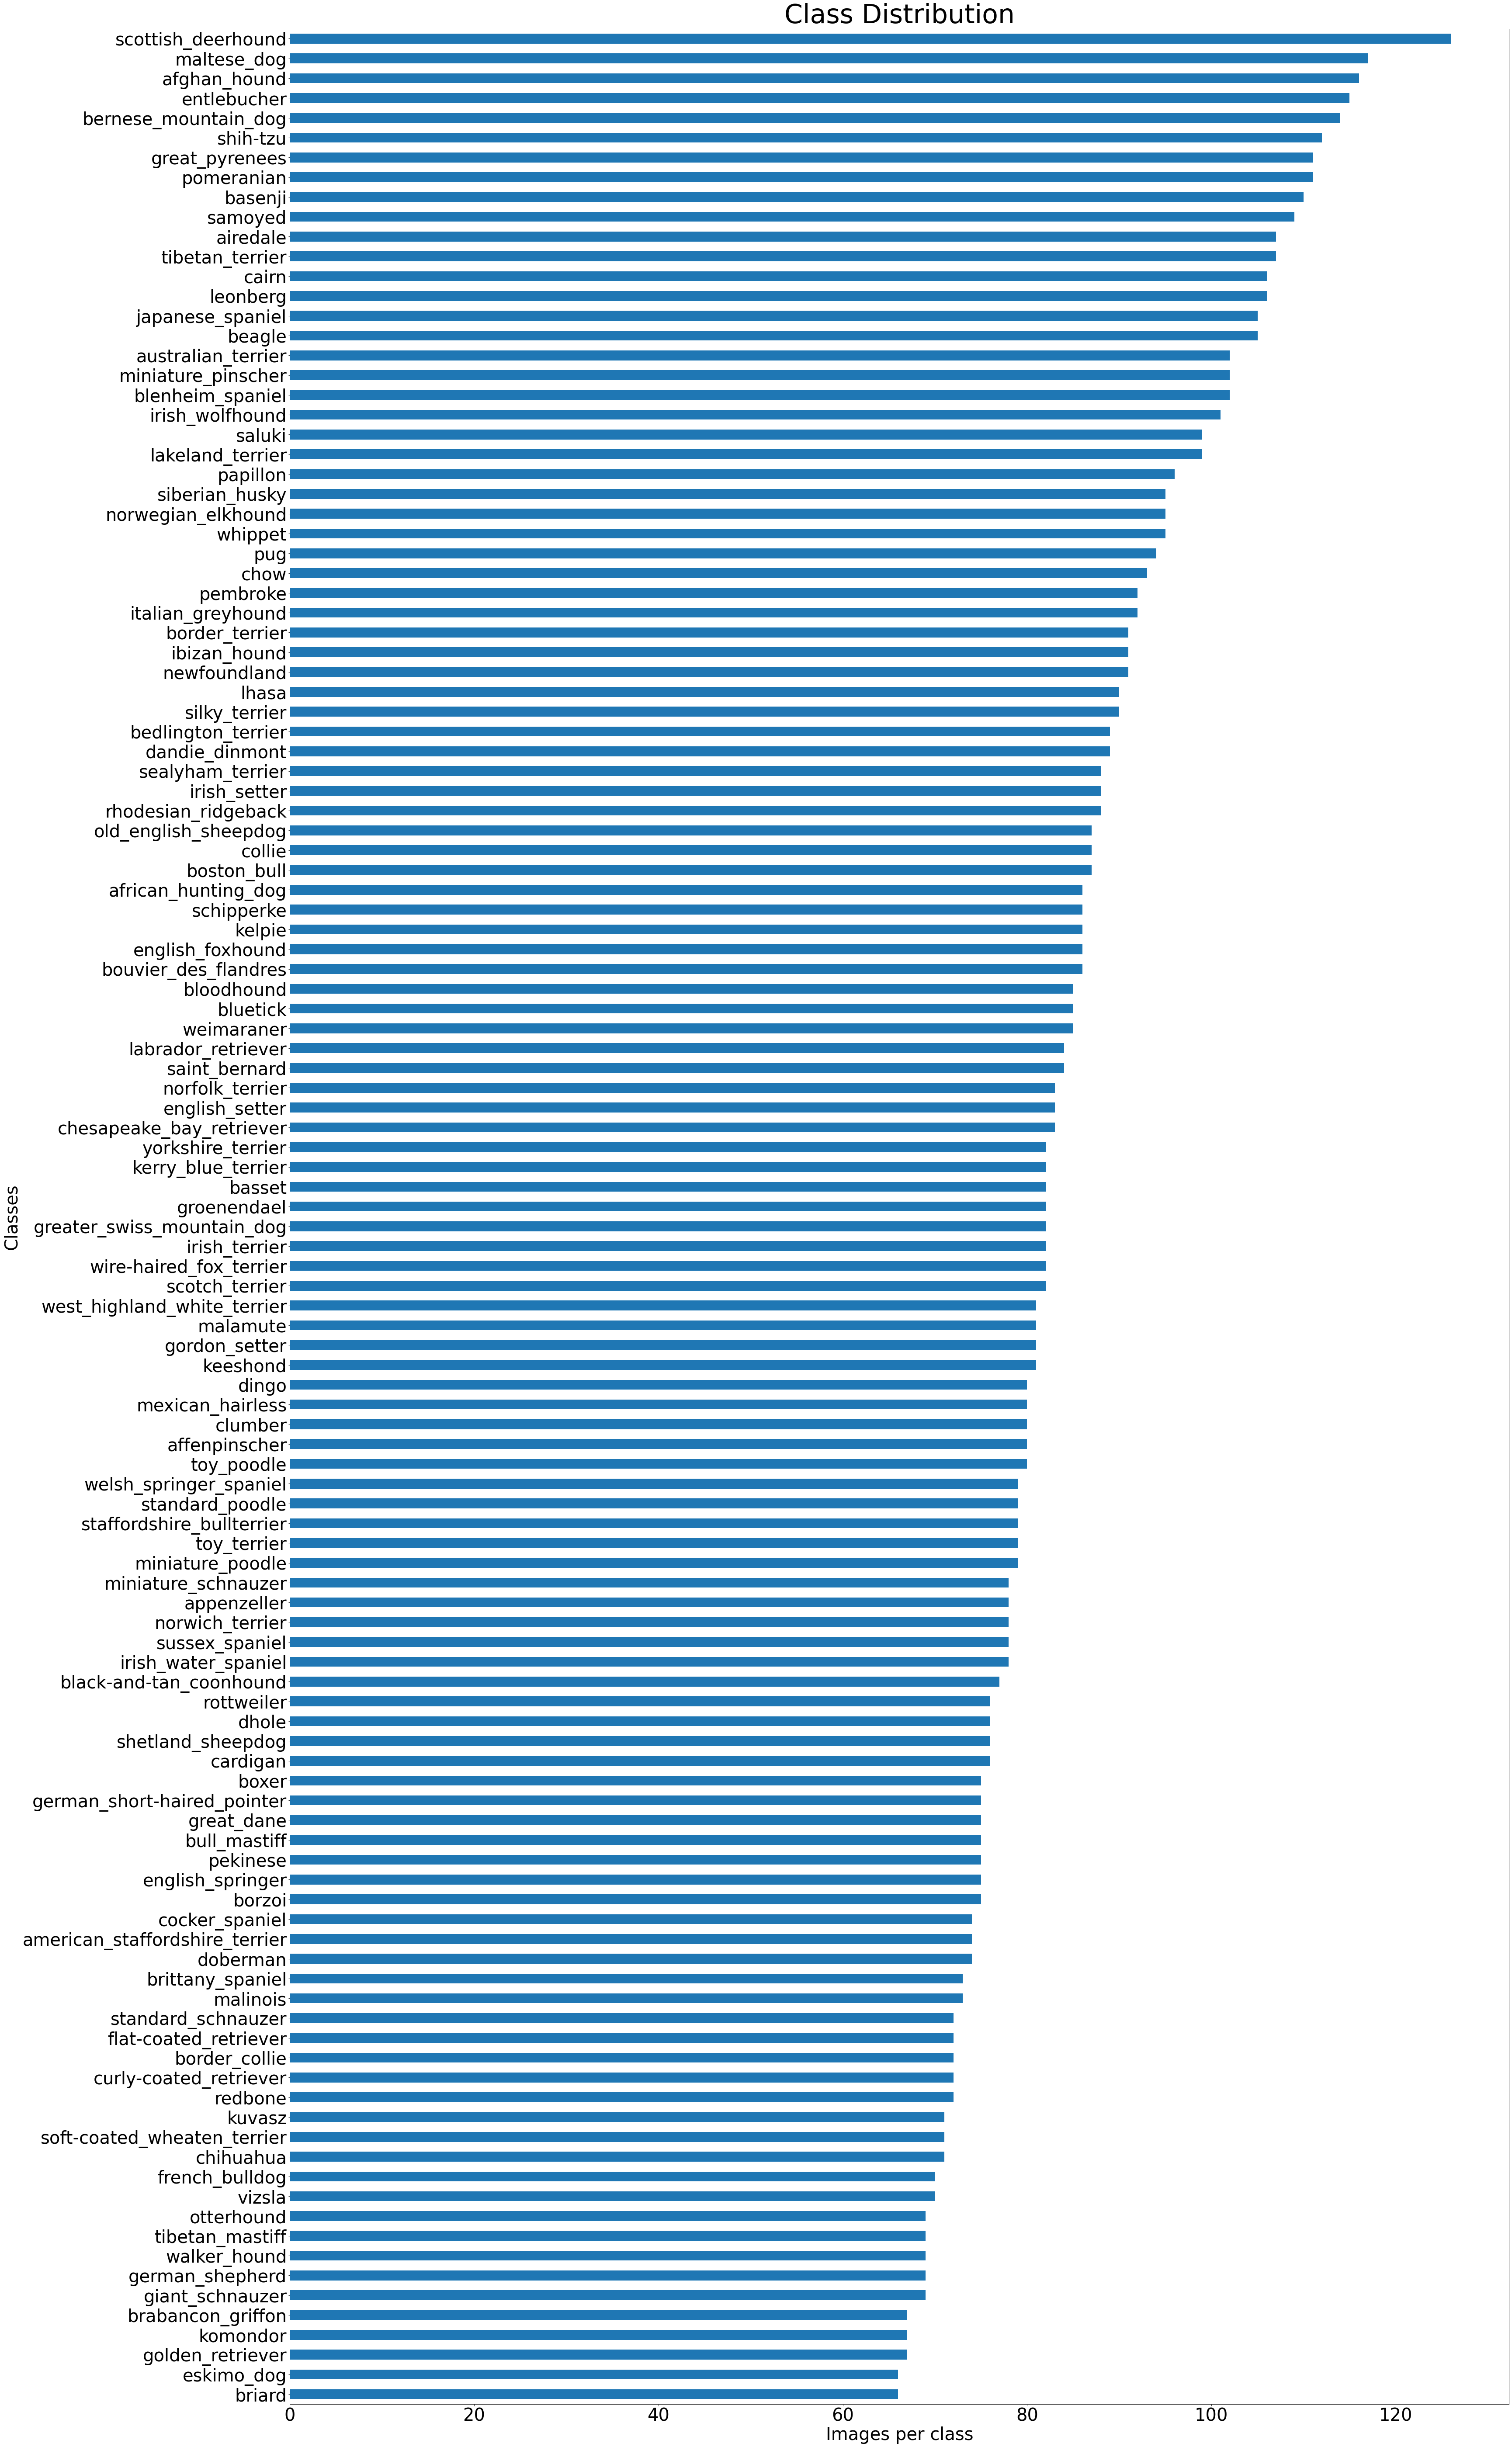

In [5]:

ax=pd.value_counts(labels['breed'],ascending=True).plot(kind='barh',fontsize="40",title="Class Distribution",figsize=(50,100))
ax.set(xlabel="Images per class", ylabel="Classes")
ax.xaxis.label.set_size(40)
ax.yaxis.label.set_size(40)
ax.title.set_size(60)
plt.show()
#plt.figure(figsize=(50,20))

In [6]:

data=Counter(list(labels["breed"]))
sort_data = sorted(data.items(), key=lambda x: x[1], reverse=True)
sort_data=pd.DataFrame(sort_data[:20],columns=["breed","count"])
labels2=[]
l=list(sort_data["breed"][0:])
for i in range(len(labels["breed"])):
    #print(labels.iloc[i]["breed"])
    if labels.iloc[i]["breed"] in l:
        
        labels2.append([labels.iloc[i]["breed"],labels.iloc[i]["id"]])
labels=pd.DataFrame(labels2,columns=["breed","id"])
labels
        

,breed,id
0,basenji,003df8b8a8b05244b1d920bb6cf451f9
1,scottish_deerhound,0042188c895a2f14ef64a918ed9c7b64
2,maltese_dog,00693b8bc2470375cc744a6391d397ec
3,cairn,00bee065dcec471f26394855c5c2f3de
4,tibetan_terrier,013f8fdf6d638c7bb042f5f17e8a9fdc
...,...,...
2179,tibetan_terrier,ffc532991d3cd7880d27a449ed1c4770
2180,airedale,ffcde16e7da0872c357fbc7e2168c05f
2181,samoyed,ffcffab7e4beef9a9b8076ef2ca51909
2182,airedale,ffe2ca6c940cddfee68fa3cc6c63213f


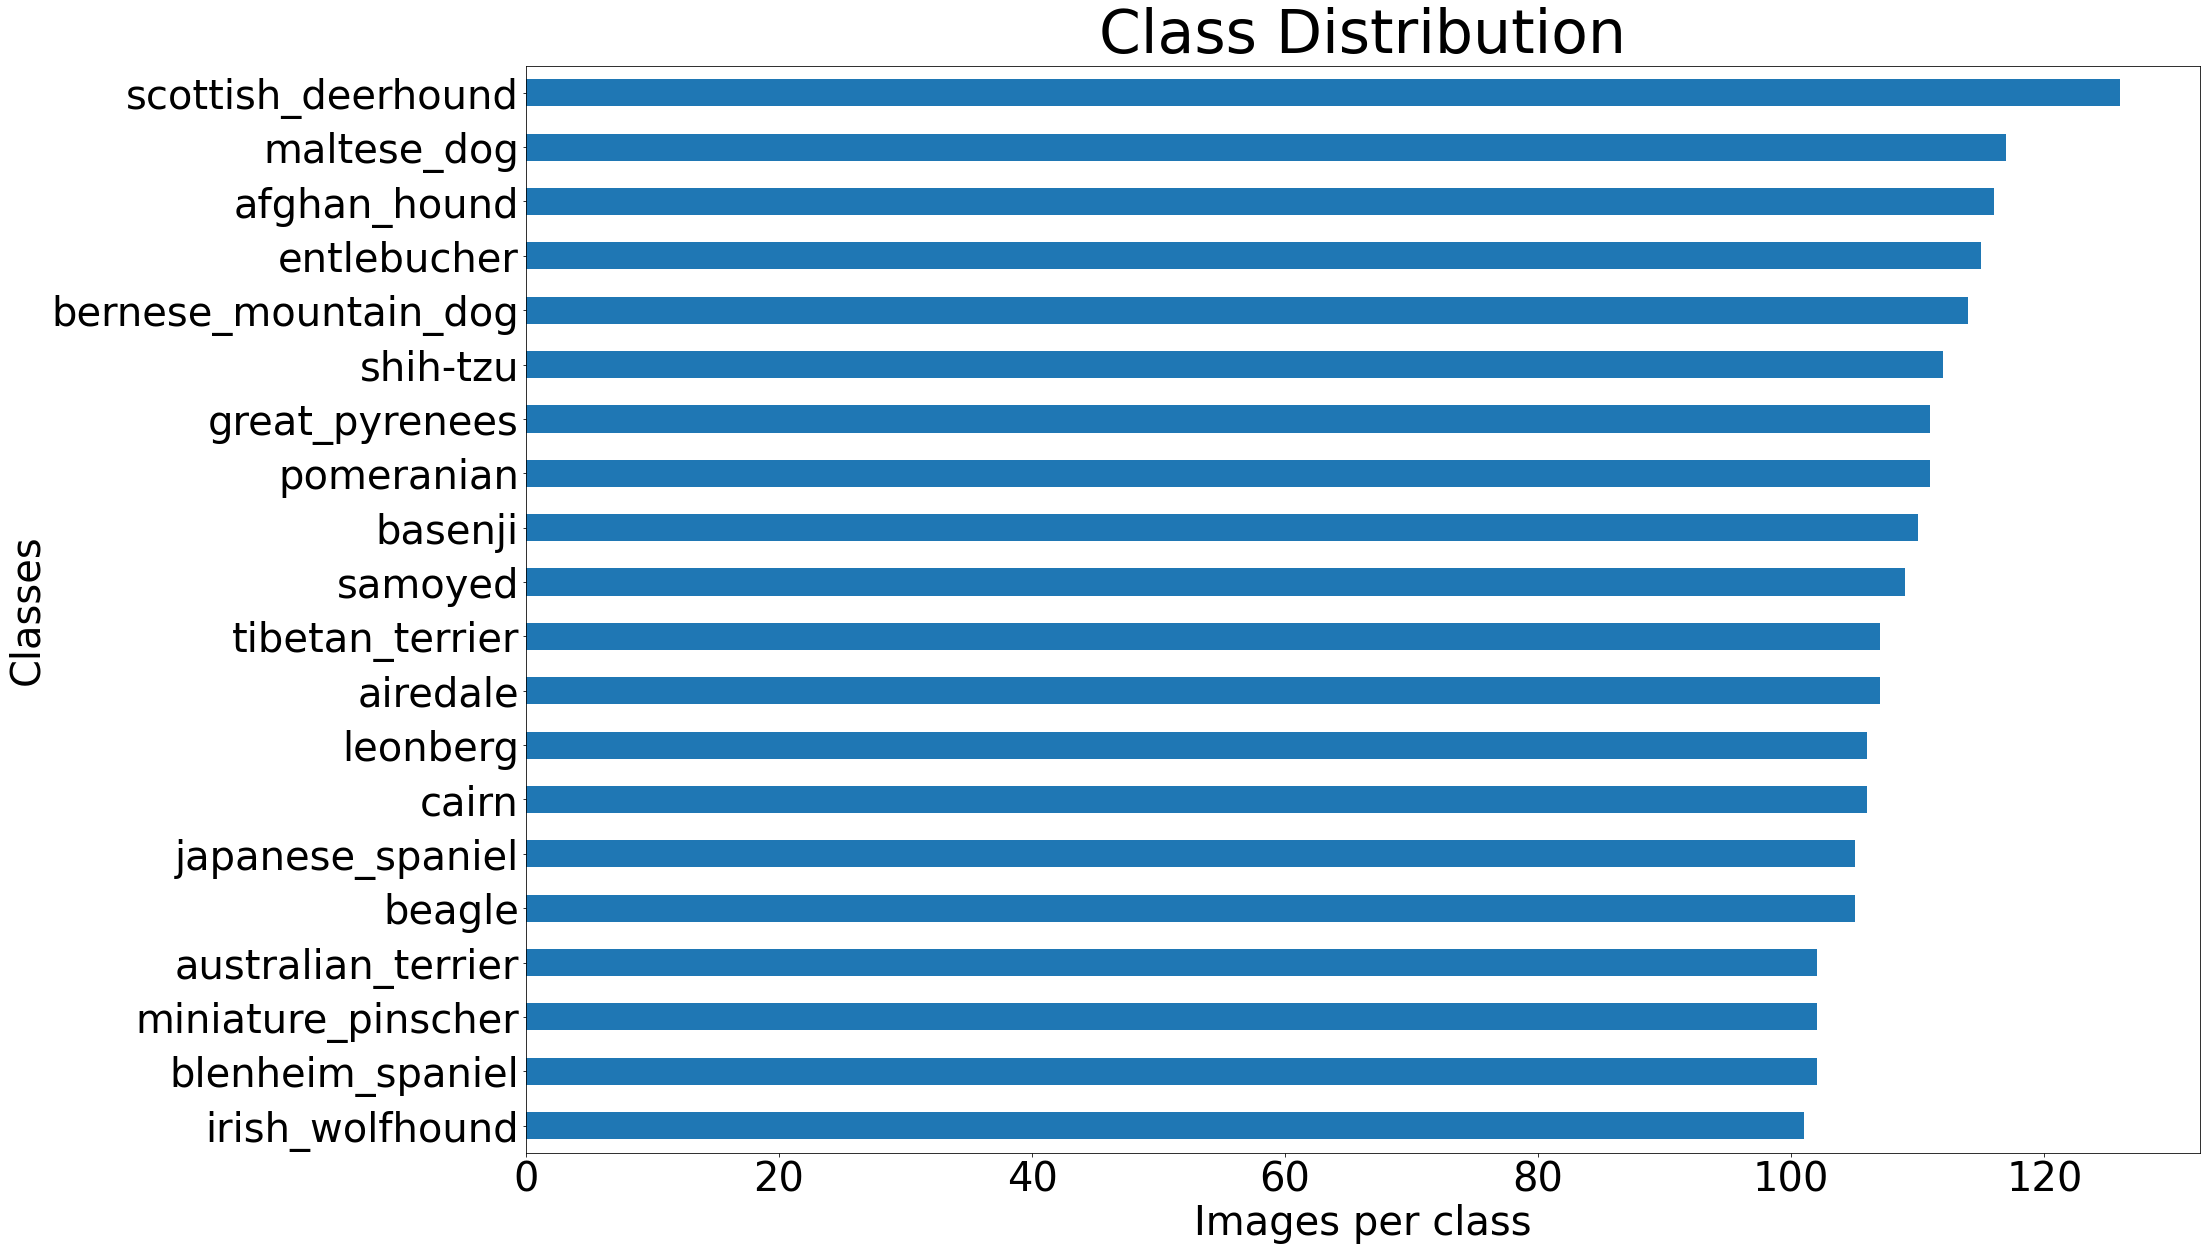

In [7]:
ax=pd.value_counts(labels['breed'],ascending=True).plot(kind='barh',fontsize="40",title="Class Distribution",figsize=(30,20))
ax.set(xlabel="Images per class", ylabel="Classes")
ax.xaxis.label.set_size(40)
ax.yaxis.label.set_size(40)
ax.title.set_size(60)
plt.show()

In [8]:
file_df = pd.DataFrame({'id':list(map(lambda x:x.replace('.jpg',''),files))})
file_df.head()

,id
0,000bec180eb18c7604dcecc8fe0dba07
1,001513dfcb2ffafc82cccf4d8bbaba97
2,001cdf01b096e06d78e9e5112d419397
3,00214f311d5d2247d5dfe4fe24b2303d
4,0021f9ceb3235effd7fcde7f7538ed62


### Mapping File with breed, maintain file read order

In [9]:
label_info = pd.merge(left=file_df, right=labels)
label_info.head()
#label_info[label_info['breed']=='siberian_husky']

,id,breed
0,003df8b8a8b05244b1d920bb6cf451f9,basenji
1,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound
2,00693b8bc2470375cc744a6391d397ec,maltese_dog
3,00bee065dcec471f26394855c5c2f3de,cairn
4,013f8fdf6d638c7bb042f5f17e8a9fdc,tibetan_terrier


### showing a few of them
#### 1st Image

In [10]:
img = plt.imread(os.path.join(data_dir,files[1]))

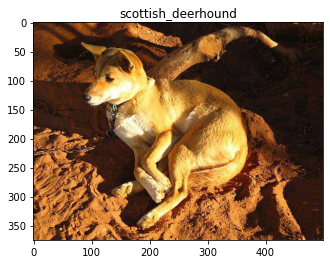

In [11]:
plt.imshow(img)
plt.title(label_info.iloc[1]['breed'])
plt.show()

### Converting target to One-Hot-Vector Format

In [12]:
num_classes = len(label_info.breed.unique())
num_classes

20

2184


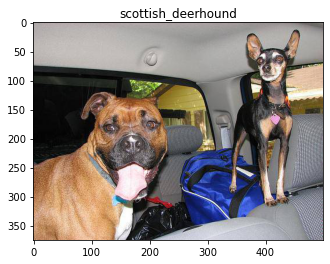

In [13]:

files2=list(labels["id"])
files2=[x+".jpg" for x in files2]
files=files2.copy()
print(len(list(labels["id"])))
img = plt.imread(os.path.join(data_dir,files[2183]))
plt.imshow(img)
plt.title(label_info.iloc[1]['breed'])
plt.show()

In [14]:
le = LabelEncoder()
breed = le.fit_transform(label_info.breed)

Y = np_utils.to_categorical(breed,num_classes=num_classes)
breed

array([ 3, 17, 13, ..., 16,  1, 14])

In [15]:
Y.shape

(2184, 20)

### Convert images to numpy array

In [16]:
input_dim = (224, 224)

X = np.zeros((Y.shape[0],*input_dim,3))

for i,img in enumerate(files):
    image = load_img(os.path.join(data_dir,img),target_size=input_dim)
    image = img_to_array(image)
    image = image.reshape((1, *image.shape))
    image = preprocess_input(image)
    X[i] = image

In [17]:
X.shape

(2184, 224, 224, 3)

### Create callbacks

In [18]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto')

<img src="https://alexisbcook.github.io/assets/global_average_pooling.png"  height="600" width="600">

In [19]:
from keras.applications.vgg19 import VGG19
from keras.models import Model
from keras.layers import Dense,GlobalAveragePooling2D, Flatten,Dropout

vgg_model = VGG19(weights='imagenet', include_top=False)

x = vgg_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
out = Dense(20, activation='softmax')(x)

model = Model(inputs=vgg_model.input, outputs=out)

for layer in vgg_model.layers:
    layer.trainable = False

from keras.optimizers import Adam
opt = Adam()

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0   

In [ ]:
history_last_layer = model.fit(X,Y,batch_size=128,epochs=10,validation_split=0.2,verbose=2,callbacks=[earlystop])
model.save('modellastlayer.h5')

Train on 1747 samples, validate on 437 samples
Epoch 1/10


In [ ]:
last_layer_model = load_model('modellastlayer.h5')
res = last_layer_model.predict(image)
s = np.argsort(res)[0][-5:]
s

In [ ]:
le.inverse_transform(s)

In [ ]:
history_last_layer.history.keys()

In [ ]:
val_acc = history_last_layer.history.get('val_acc')

In [ ]:
acc = history_last_layer.history.get('acc')

In [ ]:
overfit_info = pd.DataFrame({'acc':acc, 'val_acc':val_acc})

In [ ]:
overfit_info.plot.line()

### Apart from last layer, training one more layer

In [ ]:
from keras.applications.vgg19 import VGG19
from keras.models import Model
from keras.layers import Dense,GlobalAveragePooling2D, Flatten,Dropout

vgg_model = VGG19(weights='imagenet', include_top=False)

x = vgg_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
out = Dense(120, activation='softmax')(x)

model_few_layers = Model(inputs=vgg_model.input, outputs=out)

for layer in vgg_model.layers[:-1]:
    layer.trainable = False

for layer in vgg_model.layers[-1:]:
    layer.trainable = True

from keras.optimizers import Adam
opt = Adam()

model_few_layers.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model_few_layers.summary()

In [ ]:
history_few_layers = model_few_layers.fit(X,Y,batch_size=256,epochs=20,validation_split=0.2,verbose=2,callbacks=[earlystop])
model_few_layers.save('modelfewlayer.h5')

In [ ]:
val_acc = history_few_layers.history.get('val_acc')

In [ ]:
acc = history_few_layers.history.get('acc')

In [ ]:
overfit_info = pd.DataFrame({'acc':acc, 'val_acc':val_acc})

In [ ]:
overfit_info.plot.line()

In [ ]:
from keras.applications.vgg19 import VGG19
from keras.models import Model
from keras.layers import Dense,GlobalAveragePooling2D, Flatten,Dropout

vgg_model = VGG19(weights='imagenet', include_top=False)

x = vgg_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
out = Dense(120, activation='softmax')(x)

model_few2_layers = Model(inputs=vgg_model.input, outputs=out)

for layer in vgg_model.layers[:-2]:
    layer.trainable = False

for layer in vgg_model.layers[-2:]:
    layer.trainable = True

from keras.optimizers import Adam
opt = Adam()

model_few2_layers.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model_few2_layers.summary()

In [ ]:
history_few2_layers = model_few2_layers.fit(X,Y,batch_size=256,epochs=20,validation_split=0.2,verbose=2)
model_few2_layers.save('modelfew2layer.h5')

In [ ]:
val_acc = history_few2_layers.history.get('val_acc')

In [ ]:
acc = history_few2_layers.history.get('acc')

In [ ]:
overfit_info = pd.DataFrame({'acc':acc, 'val_acc':val_acc})

In [ ]:
overfit_info.plot.line()

### Verifying models for top 3 prediction on Training Data

In [ ]:
from keras.models import load_model

In [ ]:
def validate(X,Y):
    for model_img in ['modellastlayer.h5','modelfewlayer.h5','modelfew2layer.h5']:
        model = load_model(model_img)
        pred = model.predict(X)
        top3 = np.argsort(pred)[:,-3:]
        actual = np.argmax(Y,axis=1)
        res = top3 - actual.reshape(-1,1)
        ana = np.product(res,axis=1)
        print (model_img, np.sum(ana == 0)/ana.shape[0])

### Validating models with new data - 5 files for each type

In [ ]:
test_labels = pd.read_csv('test_labels.csv',index_col='Unnamed: 0')

In [ ]:
test_labels.rename(columns={'files':'id'},inplace=True)

In [ ]:
test_labels.head()

In [ ]:
breed = le.transform(test_labels.breed)
Y = np_utils.to_categorical(breed,num_classes=num_classes)

In [ ]:
base_dir = '.'
data_dir = os.path.join(base_dir,'Test-Dog-Breed/')
files = os.listdir(data_dir)

In [ ]:
input_dim = (224, 224)

X = np.zeros((Y.shape[0],*input_dim,3))

for i,img in enumerate(files):
    image = load_img(os.path.join(data_dir,img),target_size=input_dim)
    image = img_to_array(image)
    image = image.reshape((1, *image.shape))
    image = preprocess_input(image)
    X[i] = image

In [ ]:
X[0]

In [ ]:
def validate(X,Y):
    for model_img in ['modellastlayer.h5','modelfewlayer.h5','modelfew2layer.h5']:
        model = load_model(model_img)
        pred = model.predict(X)
        top3 = np.argsort(pred)[:,-3:]
        actual = np.argmax(Y,axis=1)
        res = top3 - actual.reshape(-1,1)
        ana = np.product(res,axis=1)
        print (model_img, np.sum(ana == 0)/ana.shape[0])

In [ ]:
validate(X,Y)

In [ ]:
model = load_model('modelfewlayer.h5')

In [ ]:
image = load_img('Test-Dog-Breed/n02085620_1',target_size=input_dim)
image = img_to_array(image)
image = image.reshape((1, *image.shape))
image = preprocess_input(image)

In [ ]:
image.shape

In [ ]:
res = model.predict(image)

In [ ]:
s = np.argsort(res)[0][-5:]
s

In [ ]:
le.inverse_transform(s)

### Image Augmentation

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model

In [ ]:
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

In [ ]:
datagen.fit(X)

In [ ]:
model = load_model('modelfewlayer.h5')

In [ ]:
history_aug_images = model.fit_generator(datagen.flow(X, Y, batch_size=256), steps_per_epoch=len(X) / 32, epochs=20, verbose=2)

In [ ]:
history_aug_images.history.keys()

In [ ]:
model.save('img_aug.h5')

In [ ]:
model = load_model('img_aug.h5')
image = load_img('gullu.jpg',target_size=input_dim)
image = img_to_array(image)
image = image.reshape((1, *image.shape))
image = preprocess_input(image)

In [ ]:
res = model.predict(image)

In [ ]:
s = np.argsort(res)[0][-5:]
s

In [ ]:
le.inverse_transform(s)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
trainX,testX,trainY,testY = train_test_split(X,Y)

In [ ]:
trainY.shape

In [ ]:
from keras.applications.vgg19 import VGG19
from keras.models import Model
from keras.layers import Dense,GlobalAveragePooling2D, Flatten,Dropout

vgg_model = VGG19(weights='imagenet', include_top=False)

x = vgg_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
out = Dense(120, activation='softmax')(x)

model_few1_layers = Model(inputs=vgg_model.input, outputs=out)

for layer in vgg_model.layers[:-1]:
    layer.trainable = False

for layer in vgg_model.layers[-1:]:
    layer.trainable = True

from keras.optimizers import Adam
opt = Adam()

model_few1_layers.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model_few1_layers.summary()

In [ ]:
datagen.fit(trainX)

In [ ]:
history_aug_images = model_few1_layers.fit_generator(datagen.flow(trainX, trainY, batch_size=256), steps_per_epoch=len(X) / 32, epochs=20, verbose=1, validation_data=(testX,testY))

In [ ]:
model_few1_layers.save('model_aug1_layer.h5')

In [ ]:
from keras.applications.vgg19 import VGG19
from keras.models import Model
from keras.layers import Dense,GlobalAveragePooling2D, Flatten,Dropout

vgg_model = VGG19(weights='imagenet', include_top=False)

x = vgg_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
out = Dense(120, activation='softmax')(x)

model_few2_layers = Model(inputs=vgg_model.input, outputs=out)

for layer in vgg_model.layers[:-2]:
    layer.trainable = False

for layer in vgg_model.layers[-2:]:
    layer.trainable = True

from keras.optimizers import Adam
opt = Adam()

model_few2_layers.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model_few2_layers.summary()

In [ ]:
history_aug2_images = model_few2_layers.fit_generator(datagen.flow(trainX, trainY, batch_size=256), steps_per_epoch=len(X) / 32, epochs=10, verbose=1, validation_data=(testX,testY))
model_few2_layers.save('model_aug2_layer.h5')

In [ ]:
model_few2_layers.save('model_aug2_layer.h5')

In [ ]:
image = load_img('gullu.jpg',target_size=input_dim)
image = img_to_array(image)
image = image.reshape((1, *image.shape))
image = preprocess_input(image)

In [ ]:
res = model_few2_layers.predict(image)

In [ ]:
s = np.argsort(res)[0][-5:]
s

In [ ]:
le.inverse_transform(s)

### Last layer Trained

In [ ]:
last_layer_model = load_model('modellastlayer.h5')

In [ ]:
res = last_layer_model.predict(image)

In [ ]:
s = np.argsort(res)[0][-5:]
s

In [ ]:
le.inverse_transform(s)

In [ ]:
last_2_layer_model = load_model('modelfew2layer.h5')

In [ ]:
res = last_layer_model.predict(image)

In [ ]:
s = np.argsort(res)[0][-5:]
s

In [ ]:
le.inverse_transform(s)